# Learned Tuner Evaluation

In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

# Loading Model

In [5]:
path = '/data/models/ltune/qlsm-small/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])
design_type, bounds

(<Policy.QFixed: 4>,
 LSMBounds(max_considered_levels=20, bits_per_elem_range=(1, 10), size_ratio_range=[2, 31], page_sizes=[4, 8, 16], entry_sizes=[1024, 2048, 4096, 8192], memory_budget_range=[5, 20], selectivity_range=[1e-07, 1e-09], elements_range=[100000000, 1000000000]))

In [6]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_10.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [7]:
# torchinfo.summary(model, (1, len(config["ltune"]["input_features"])), device='cpu')

# Util Module    

In [8]:
ltune_util = LTuneEvalUtil(config, model, design_type)

In [9]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
out, design
# system

(tensor([[7.8771, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CatBackward0>),
 LSMDesign(h=7.877104759216309, T=30, policy=<Policy.QFixed: 4>, Q=2, Y=1.0, Z=1.0, K=[]))

# Training Loss

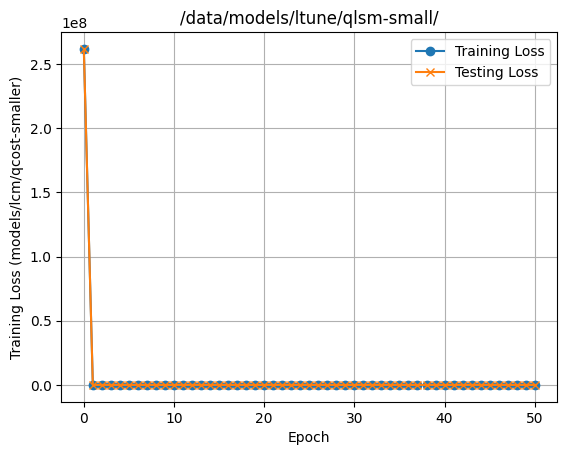

In [10]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[0:]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

In [11]:
losses.idxmin()

epoch          0
train_loss    50
test_loss     49
dtype: int64

# Evaluation

In [12]:
np.random.seed(0)
num_samples = 5000
default_sys = System()
table = []
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval()
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']

In [14]:
wl_cols = ['z0', 'z1', 'q', 'w', 'H', 'N']
stune_cols = ['stune_h', 'stune_T', 'stune_level', 'stune_Q']
ltune_cols = ['ltune_h', 'ltune_T', 'ltune_level', 'ltune_Q']
cost_cols = ['stune_cost', 'stune_loss', 'ltune_cost', 'ltune_loss'] #, 'ltune_loss_direct']
delta_cols = ['delta_cost', 'delta_loss']
cols = wl_cols + stune_cols + ltune_cols + cost_cols + delta_cols
table.sort_values(by='ltune_level', ascending=False).head(20)[cols]

KeyError: "['stune_K', 'ltune_K'] not in index"

In [ ]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

In [ ]:
fig, ax = plt.subplots()
data = table['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - Analytical Cost Model')
ax.vlines(x=0, ymin=0, ymax=0.3, color='black')
# ax.vlines(x=-0.1, ymin=0, ymax=0.3, color='black')
# ax.legend()
plt.show()

Performance values within 5% cutoff

In [ ]:
cutoff = 0.2
len(table[table.delta_cost > -cutoff]) / len(table)

Positive Performance Values

In [ ]:
table[table.delta_cost > 0][cols]

## Learned Cost Model

In [ ]:
fig, ax = plt.subplots()
data = table['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - C = LCM')
ax.vlines(x=0, ymin=0, ymax=0.14, color='black')
plt.show()

## Difference in ACM and LCM

In [ ]:
fig, ax = plt.subplots()
ldata = table['ltune_diff']
sdata = table['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [ ]:
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [ ]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0.5]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads', labelpad=6)
    ax.set_ylabel('Range-Reads', labelpad=6)
    ax.set_zlabel('Writes', labelpad=6)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc, pad=0.11, shrink=0.6)
    cbar.set_label(trend)
    cbar.ax.tick_params(labelsize=12)
    font = {'size': 12}
    ax.tick_params('x', labelsize=font['size'])
    ax.tick_params('y', labelsize=font['size'])
    ax.tick_params('z', labelsize=font['size'])
    
    return fig, ax, sc, cbar

In [ ]:
# plt.rcParams.update({'font.size': 18})
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
cbar.set_label('Size Ratio (T)')
ax.set_title('Analytical Tuner')
plt.show()
# save_fig(fig, 'analytical_tuner_size_ratio.pdf')

In [ ]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
ax.set_title('Learned Tuner')
cbar.set_label('Size Ratio (T)')
plt.show()
# save_fig(fig, 'learned_tuner_size_ratio.pdf')

In [ ]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

In [ ]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

In [ ]:
# fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_Q')
# ax.set_title('Analytical')
# plt.show()

In [ ]:
# fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_Q')
# ax.set_title('Learned')
# plt.show()

In [ ]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='delta_cost')
ax.set_title('Delta Cost')
plt.show()

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (0.2)
groupa = table[(table['delta_cost'] > -cutoff)]
groupb = table[(table['delta_cost'] < -cutoff)]
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor', alpha=1)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent', alpha=0.1)
ax.set_title(f'Perfromance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend()
plt.show()

## 

In [ ]:
t = pd.DataFrame(table['ltune_K'].tolist())
t.sort_values(by=2)

## 